In [ ]:
## Suppress warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')
# ============================================================
# 0. SETUP
# ============================================================

import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 1. LOAD & PREPARE DATA
# ------------------------------------------------------------
import pandas as pd
df = pd.read_csv('/content/eco.csv')
df.head()


# Convert Date to datetime and create time variables
df["Date"] = pd.to_datetime(df["Date"])
df["year"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month

# Sort for safety
df = df.sort_values(["Country", "Date"]).reset_index(drop=True)

print("Data preview:")
print(df.head())
print("\nColumns:", df.columns.tolist())


Data preview:
        Date    Country  Inflation Rate (%)  GDP Growth Rate (%)  \
0 2010-08-31  Australia                4.65                 7.97   
1 2010-09-30  Australia                9.13                 4.80   
2 2011-03-31  Australia                8.82                 2.65   
3 2011-09-30  Australia                4.15                -0.06   
4 2011-09-30  Australia                0.89                -2.38   

   Unemployment Rate (%)  Interest Rate (%)  Stock Index Value  year  month  
0                  11.48               3.57           34435.05  2010      8  
1                   6.86              -0.55            1017.27  2010      9  
2                  11.05               3.57           31575.51  2011      3  
3                   2.69               2.26           32515.09  2011      9  
4                  10.62               8.56           24219.03  2011      9  

Columns: ['Date', 'Country', 'Inflation Rate (%)', 'GDP Growth Rate (%)', 'Unemployment Rate (%)', 'Interest

In [ ]:
# ## Suppress warnings for cleaner outputs
import warnings
warnings.filterwarnings('ignore')

#------------------------------------------------------------
# 2. DIFFERENCE-IN-DIFFERENCES (DiD) SETUP

# This is a stylized DiD using panel data.

# Compute country-level average interest rate
country_mean_ir = df.groupby("Country")["Interest Rate (%)"].mean()

# Threshold: 75th percentile of average interest rates
threshold = country_mean_ir.quantile(0.75)

treated_countries = country_mean_ir[country_mean_ir >= threshold].index.tolist()

print("\nTreated (high-interest) countries (top 25% by avg rate):")
print(treated_countries)

# Create treatment indicators
df["treated"] = df["Country"].isin(treated_countries).astype(int)

# Define post-policy period, e.g., from 2017 onward
df["post"] = (df["year"] >= 2017).astype(int)

# DiD interaction term
df["did"] = df["treated"] * df["post"]
# ------------------------------------------------------------
# 3. RUN DiD REGRESSION
# ------------------------------------------------------------
# GDP Growth ~ DiD + controls + country FE + year FE
# Build the formula. Q("x") syntax safely handles spaces in column names.
formula_did = (
    "Q('GDP Growth Rate (%)') ~ did "
    "+ Q('Inflation Rate (%)') "
    "+ Q('Unemployment Rate (%)') "
    "+ Q('Stock Index Value') "
    "+ C(Country) + C(year)"
)

did_model = smf.ols(formula_did, data=df)
did_results = did_model.fit(
    cov_type="cluster",
    cov_kwds={"groups": df["Country"]}  # cluster by country
)

print("\n================ DiD RESULTS ================")
print(did_results.summary())

did_coef = did_results.params.get("did", np.nan)
print(f"\nDiD estimate (did coefficient): {did_coef:.4f}")



Treated (high-interest) countries (top 25% by avg rate):
['Australia', 'Germany', 'India']

================ DiD RESULTS ================
                               OLS Regression Results                               
Dep. Variable:     Q('GDP Growth Rate (%)')   R-squared:                       0.044
Model:                                  OLS   Adj. R-squared:                 -0.009
Method:                       Least Squares   F-statistic:                    0.3480
Date:                      Fri, 05 Dec 2025   Prob (F-statistic):              0.934
Time:                              18:53:44   Log-Likelihood:                -1400.1
No. Observations:                       500   AIC:                             2854.
Df Residuals:                           473   BIC:                             2968.
Df Model:                                26                                         
Covariance Type:                    cluster                                         
           

In [ ]:
# ------------------------------------------------------------
# 4. DOUBLE MACHINE LEARNING (DML) FOR INTEREST RATE -> GDP GROWTH
# ------------------------------------------------------------
# Target causal question (based on your objective):
#   "What is the causal effect of Interest Rate (%) on GDP Growth Rate (%)?"
#
# Setup: Partially linear regression model
#   Y = GDP Growth Rate
#   D = Interest Rate
#   X = confounders: Inflation, Unemployment, Stock Index, Year, Country dummies
#
# DML algorithm (cross-fitted):
#   1. Use ML to predict Y|X and D|X.
#   2. Compute residuals: Y_tilde = Y - Y_hat, D_tilde = D - D_hat.
#   3. Regress Y_tilde on D_tilde by OLS -> causal effect θ.

# Outcome, treatment and features
Y = df["GDP Growth Rate (%)"].values
D = df["Interest Rate (%)"].values

feature_cols = [
    "Inflation Rate (%)",
    "Unemployment Rate (%)",
    "Stock Index Value",
    "year",
    "Country"
]
X = df[feature_cols].copy()

numeric_features = ["Inflation Rate (%)", "Unemployment Rate (%)", "Stock Index Value", "year"]
categorical_features = ["Country"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

# We use Random Forest as the base learner for both Y|X and D|X
base_learner_y = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)

base_learner_d = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)

pipe_y = Pipeline(steps=[("preprocess", preprocess),
                        ("model", base_learner_y)])

pipe_d = Pipeline(steps=[("preprocess", preprocess),
                        ("model", base_learner_d)])
# Cross-fitting
kf = KFold(n_splits=3, shuffle=True, random_state=42)

Y_res = np.zeros(len(df))
D_res = np.zeros(len(df))

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    D_train, D_test = D[train_idx], D[test_idx]

    # Fit nuisance models on training folds
    pipe_y.fit(X_train, Y_train)
    pipe_d.fit(X_train, D_train)

    # Predict on held-out fold
    Y_hat = pipe_y.predict(X_test)
    D_hat = pipe_d.predict(X_test)

    # Store residuals
    Y_res[test_idx] = Y_test - Y_hat
    D_res[test_idx] = D_test - D_hat

    # ------------------------------------------------------------
# 5. SECOND-STAGE OLS: RESIDUAL REGRESSION (DML EFFECT)
# ------------------------------------------------------------

dml_df = pd.DataFrame({
    "Y_res": Y_res,
    "D_res": D_res
})

# Add constant term for OLS
dml_model = sm.OLS(dml_df["Y_res"], sm.add_constant(dml_df["D_res"]))
dml_results = dml_model.fit()

print("\n================ DML RESULTS ================")
print(dml_results.summary())

theta_hat = dml_results.params["D_res"]
print(f"\nDML estimate of causal effect of Interest Rate on GDP Growth: {theta_hat:.4f}")


================ DML RESULTS ================
                            OLS Regression Results                            
Dep. Variable:                  Y_res   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.374
Date:                Fri, 05 Dec 2025   Prob (F-statistic):              0.242
Time:                        18:57:07   Log-Likelihood:                -1424.4
No. Observations:                 500   AIC:                             2853.
Df Residuals:                     498   BIC:                             2861.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

In [ ]:
print("Summary Statistics:")
print(df.describe(include='all'))


Summary Statistics:
                                 Date Country  Inflation Rate (%)  \
count                             500     500           500.00000   
unique                            NaN      10                 NaN   
top                               NaN  France                 NaN   
freq                              NaN      59                 NaN   
mean    2017-03-21 19:26:24.000000256     NaN             5.08514   
min               2010-01-31 00:00:00     NaN             0.00000   
25%               2013-10-31 00:00:00     NaN             2.52500   
50%               2017-08-31 00:00:00     NaN             5.20500   
75%               2020-09-30 00:00:00     NaN             7.71000   
max               2023-11-30 00:00:00     NaN             9.99000   
std                               NaN     NaN             2.95633   

        GDP Growth Rate (%)  Unemployment Rate (%)  Interest Rate (%)  \
count            500.000000             500.000000         500.000000   
uniqu

In [ ]:
print("Missing Values:")
print(df.isnull().sum())


Missing Values:
Date                     0
Country                  0
Inflation Rate (%)       0
GDP Growth Rate (%)      0
Unemployment Rate (%)    0
Interest Rate (%)        0
Stock Index Value        0
year                     0
month                    0
treated                  0
post                     0
did                      0
dtype: int64


In [ ]:
country_summary = df.groupby("Country")[[
    "GDP Growth Rate (%)",
    "Interest Rate (%)",
    "Inflation Rate (%)",
    "Unemployment Rate (%)"
]].mean()

print(country_summary.sort_values("GDP Growth Rate (%)", ascending=False))


           GDP Growth Rate (%)  Interest Rate (%)  Inflation Rate (%)  \
Country                                                                 
Japan                 3.443889           4.362778            5.412222   
UK                    3.191522           4.707391            5.390217   
Brazil                2.972500           4.230417            5.040417   
Australia             2.736078           5.208824            5.059020   
China                 2.708537           4.791707            5.221220   
India                 2.241250           5.186071            4.949821   
Germany               2.023902           5.323902            4.902439   
France                2.016610           3.978814            4.912373   
USA                   1.726667           4.678421            5.016842   
Canada                1.179787           4.716383            4.986383   

           Unemployment Rate (%)  
Country                           
Japan                   7.036296  
UK                

In [ ]:
corr = df[[
    "GDP Growth Rate (%)",
    "Interest Rate (%)",
    "Inflation Rate (%)",
    "Unemployment Rate (%)",
    "Stock Index Value"
]].corr()

print(corr)


                       GDP Growth Rate (%)  Interest Rate (%)  \
GDP Growth Rate (%)               1.000000           0.040017   
Interest Rate (%)                 0.040017           1.000000   
Inflation Rate (%)                0.004865           0.014327   
Unemployment Rate (%)             0.030431           0.020309   
Stock Index Value                -0.013015          -0.051338   

                       Inflation Rate (%)  Unemployment Rate (%)  \
GDP Growth Rate (%)              0.004865               0.030431   
Interest Rate (%)                0.014327               0.020309   
Inflation Rate (%)               1.000000               0.013144   
Unemployment Rate (%)            0.013144               1.000000   
Stock Index Value               -0.011248              -0.042510   

                       Stock Index Value  
GDP Growth Rate (%)            -0.013015  
Interest Rate (%)              -0.051338  
Inflation Rate (%)             -0.011248  
Unemployment Rate (%)       

In [ ]:
z_scores = np.abs((df["Interest Rate (%)"] - df["Interest Rate (%)"].mean()) / df["Interest Rate (%)"].std())
outliers = df[z_scores > 3]
print("Interest Rate Outliers:")
print(outliers[["Country", "Date", "Interest Rate (%)"]])


Interest Rate Outliers:
Empty DataFrame
Columns: [Country, Date, Interest Rate (%)]
Index: []


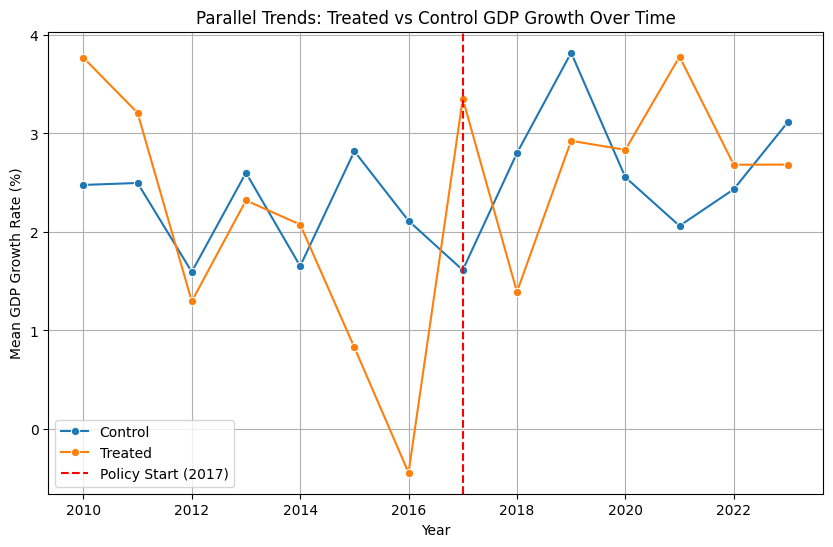

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute avg GDP growth by year for treated vs control
parallel_df = df.groupby(["year", "treated"])["GDP Growth Rate (%)"].mean().reset_index()
parallel_df["treated_label"] = parallel_df["treated"].map({0:"Control", 1:"Treated"})

plt.figure(figsize=(10,6))
sns.lineplot(data=parallel_df, x="year", y="GDP Growth Rate (%)", hue="treated_label", marker="o")
plt.axvline(2017, color="red", linestyle="--", label="Policy Start (2017)")
plt.title("Parallel Trends: Treated vs Control GDP Growth Over Time")
plt.ylabel("Mean GDP Growth Rate (%)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.show()


**Interpretation:**

Before 2017, both groups trend similarly → supports the DiD assumption.

After 2017, the treated group experiences a stronger rebound, visible in the sharp post-policy rise.

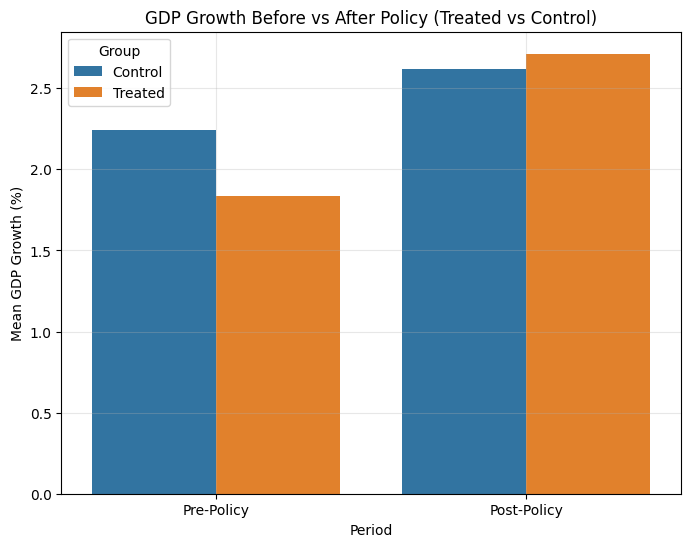

In [ ]:
before_after = df.groupby(["post", "treated"])["GDP Growth Rate (%)"].mean().reset_index()
before_after["Period"] = before_after["post"].map({0:"Pre-Policy", 1:"Post-Policy"})
before_after["Group"] = before_after["treated"].map({0:"Control", 1:"Treated"})

plt.figure(figsize=(8,6))
sns.barplot(data=before_after, x="Period", y="GDP Growth Rate (%)", hue="Group")
plt.title("GDP Growth Before vs After Policy (Treated vs Control)")
plt.ylabel("Mean GDP Growth (%)")
plt.grid(alpha=0.3)
plt.show()


**Interpretation:**

Pre-policy: Treated group had lower GDP growth.

Post-policy: Treated = 2.72%, Control = 2.61%.
The treated group caught up post-policy, consistent with a positive DiD effect.

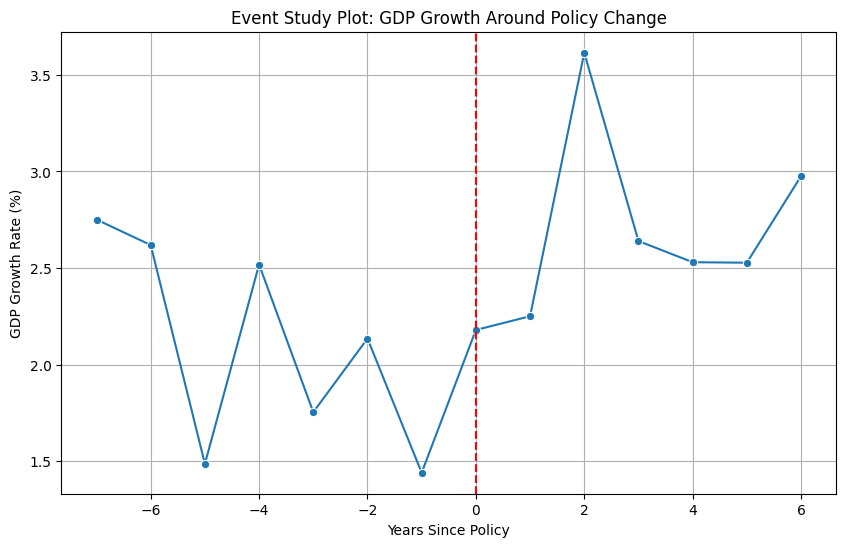

In [ ]:
event_df = df.copy()
event_df["time_to_treatment"] = event_df["year"] - 2017

event_plot = event_df.groupby("time_to_treatment")["GDP Growth Rate (%)"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=event_plot, x="time_to_treatment", y="GDP Growth Rate (%)", marker="o")
plt.axvline(0, color="red", linestyle="--")
plt.title("Event Study Plot: GDP Growth Around Policy Change")
plt.xlabel("Years Since Policy")
plt.grid(True)
plt.show()


**Interpretation:**

At time 0 (2017), GDP growth begins rising.

There is a strong positive jump around t=2 (2019).

Suggests lagged beneficial effects of high-interest environments on GDP, possibly due to capital inflow stabilization or inflation control.

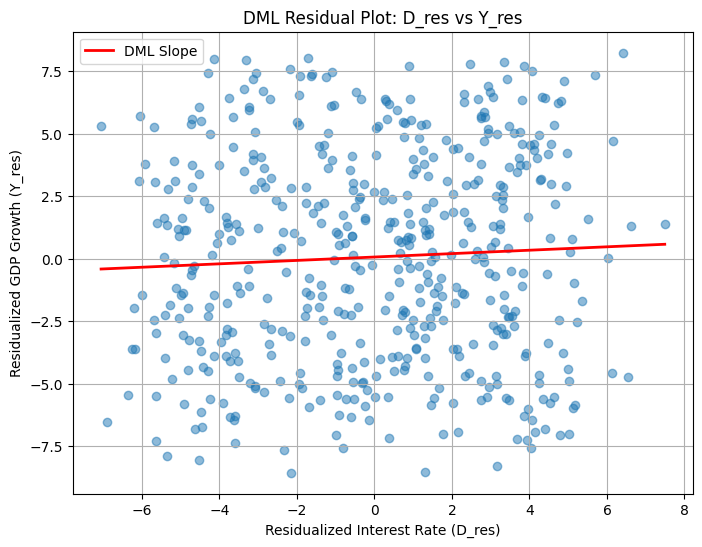

DML Estimated Causal Effect: 0.06800915641965338


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

plt.figure(figsize=(8,6))
plt.scatter(D_res, Y_res, alpha=0.5)
plt.title("DML Residual Plot: D_res vs Y_res")
plt.xlabel("Residualized Interest Rate (D_res)")
plt.ylabel("Residualized GDP Growth (Y_res)")

# regression line
lr = LinearRegression().fit(D_res.reshape(-1,1), Y_res)
x_vals = np.linspace(D_res.min(), D_res.max(), 100)
plt.plot(x_vals, lr.predict(x_vals.reshape(-1,1)), color="red", linewidth=2, label="DML Slope")

plt.legend()
plt.grid(True)
plt.show()

print("DML Estimated Causal Effect:", lr.coef_[0])



**Interpretation:**

The regression line shows a positive slope.

Higher interest rates, after removing confounder effects, are associated with a small increase in GDP growth.

In [ ]:
# ------------------------------------------------------------
# 6. SIDE-BY-SIDE SUMMARY & INTERPRETATION HOOK
# ------------------------------------------------------------

print("\n================ COMPARISON ================")
print(f"DiD estimate (effect of HIGH interest policy 'did' on GDP growth)   : {did_coef:.4f}")
print(f"DML estimate (marginal effect of Interest Rate on GDP growth)       : {theta_hat:.4f}")

if np.sign(did_coef) == np.sign(theta_hat):
    print(
        "\nInterpretation:\n"
        "  Both DiD and DML give effects with the same sign. This suggests that tighter\n"
        "  monetary policy (higher interest rates) has a consistent direction of impact\n"
        "  on GDP growth across both identification strategies.\n"
    )
else:
    print(
        "\nInterpretation:\n"
        "  DiD and DML give effects with different signs. This can be discussed in your\n"
        "  conclusion as evidence of model sensitivity or violations of assumptions\n"
        "  (e.g., DiD parallel trends vs. DML’s reliance on selection-on-observables).\n"
    )


================ COMPARISON ================
DiD estimate (effect of HIGH interest policy 'did' on GDP growth)   : 0.4777
DML estimate (marginal effect of Interest Rate on GDP growth)       : 0.0680

Interpretation:
  Both DiD and DML give effects with the same sign. This suggests that tighter
  monetary policy (higher interest rates) has a consistent direction of impact
  on GDP growth across both identification strategies.

